In [3]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib.pyplot as mpl 
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from scipy.optimize import curve_fit
import os
from numpy import asarray
from numpy import savetxt

In [5]:
import pims
import pySPM as spm 
import trackpy as tp
import glob
from scipy import ndimage, misc
from itertools import chain

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        self.filenames = filename_pattern
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").correct_plane().pixels for s in self.scans])
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype
    
if False:
    frames = SXMReader("-60VG_dense_02102020/*.sxm")
    molecule_size = 13
    min_mass = 5.0
    min_size = 15.0
    max_ecc = 0.3
if False:
    frames = SXMReader("data_high_density/*.sxm")
    molecule_size = 21
    min_mass = 5.0
    min_size = 4.0
    max_ecc = 0.3
if False:
    frames = SXMReader("examples/gate_dep/*.sxm")
    molecule_size = 7
    min_mass = 0.1
    min_size = 1.0
    max_ecc = 0.3
if False:
    frames = SXMReader("electromigration_6/Image_951.sxm") # Moire perfect lattice
    molecule_size = 11
    min_mass = 1.0
    min_size = 1.0
    max_ecc = 0.5
if False:
    frames = SXMReader("electromigration_6/Image_951.sxm")
    molecule_size = 11
    min_mass = 1.0
    min_size = 1.0
    max_ecc = 0.5
if False:
    frames = SXMReader("radial distribution_12052019/*.sxm")
    molecule_size = 7
    min_mass = 0.1
    min_size = 1.0
    max_ecc = 0.3
if False:
    n_range = range(50, 52)
    N = len(n_range)
    frames = SXMReader(["electromigration_8/Image_{0:03}.sxm".format(i) for i in n_range])
    molecule_size = 7
    min_mass = 1.0
    min_size = 1.0
    max_ecc = 0.3  
if False:
    n_range = range(217, 218)
    N = len(n_range)
    frames = SXMReader(["electromigration_8/Image_{0:03}.sxm".format(i) for i in n_range])
    molecule_size = 7
    min_mass = 1.0
    min_size = 1.0
    max_ecc = 0.3  
    #print(frames[0])
if True:
    frames = SXMReader(["radial distribution_12052019/Image_207.sxm"])
    molecule_size = 9
    min_mass = 1.0
    min_size = 2.0
    max_ecc = 0.3  
    
#plt.imshow(frames[7])

Frame 0: 24 features


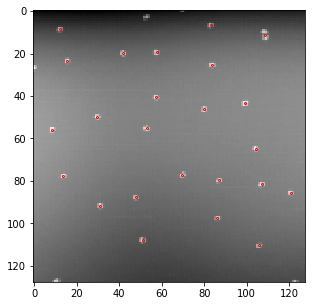

In [6]:
frame_id = 0
features = tp.batch(frames, molecule_size, minmass=min_mass, separation=3)
tp.annotate(features[features['frame']==frame_id], frames[frame_id], plot_style={'markersize' : 1, 'alpha':1})

scaled_features = features.copy()
scaled_features['x'] *= frames.meters_per_pixel*1e9
scaled_features['y'] *= frames.meters_per_pixel*1e9

In [7]:
boundary = (0, frames.frame_shape[0], 0, frames.frame_shape[1])
print(boundary)

(0, 128, 0, 128)


In [8]:
#linear interpolation of t in range (a,b)
def lerp(a, b, t):
    return a*(1.0-t)+b*t

search radius: 40.03476749895836
number of neighbors: 8.0
Delta_theta: 45.0
search radius: 40.03476749895836
number of neighbors: 8.0
Delta_theta: 45.0


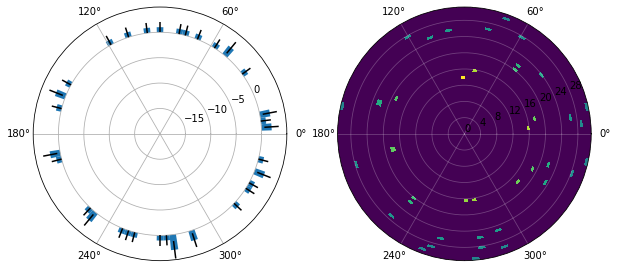

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


search radius: 40.03476749895836
number of neighbors: 8.0
Delta_theta: 45.0
search radius: 40.03476749895836
number of neighbors: 8.0
Delta_theta: 45.0


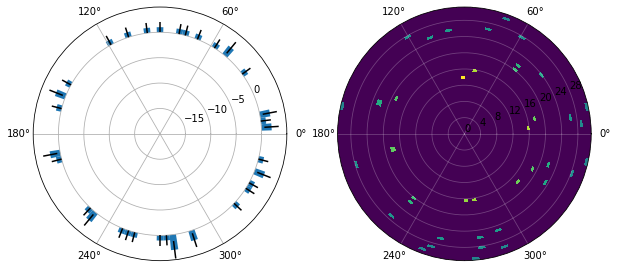

search radius: 40.03476749895836
number of neighbors: 8.0
Delta_theta: 45.0
search radius: 40.03476749895836
number of neighbors: 8.0
Delta_theta: 45.0


KeyError: 'frame'

In [9]:
from trackpy.utils import cKDTree, guess_pos_columns
from trackpy.static import MAX_ARRAY_SIZE 
# modified from pair_correlation_2d
def angular_correlation(feat, search_radius=None, search_radius_factor=2, fraction=1., dtheta=np.pi*0.025, dr=None, dr_factor=None, p_indices=None,
                        ndensity=None, boundary=None, handle_edge=True,
                        max_rel_ndensity=10, remove_nearest_neighbor=True, radial_only=False, g6_only=False):
    """Calculate the angular distribution function in 2 dimensions.
    Parameters
    ----------
    feat : Pandas DataFrame
        DataFrame containing the x and y coordinates of particles
    search_radius : float
        Maximum distance to calculate g(r)
    search_radius_factor : float
        if search_radius is not specified, specifies search_radius in approximate lattice constants, estimated from the density
    fraction : float, optional
        The fraction of particles to calculate g(r) with. May be used to
        increase speed of function. Particles selected at random.
    dtheta : float, optional
        The bin width
    p_indices : list or ndarray, optional
        Only consider a pair of particles if one of them is in 'p_indices'.
        Uses zero-based indexing, regardless of how 'feat' is indexed.
    ndensity : float, optional
        Density of particle packing. If not specified, density will be
        calculated assuming rectangular homogeneous arrangement.
    boundary : tuple, optional
        Tuple specifying rectangular prism boundary of particles (xmin, xmax,
        ymin, ymax). Must be floats. Default is to assume a rectangular packing.
        Boundaries are determined by edge particles.
    handle_edge : boolean, optional
        If true, compensate for reduced area around particles near the edges.
    max_rel_ndensity : number, optional
        The relative maximum density deviation, used to estimate the maximum
        number of neighbours. Lower numbers increase performance, until the
        method fails because there are more neighbours than expected.
    remove_nearest_neighbor : boolean, optional
        If true, the nearest neighbor of each point is excluded to avoid a giant peak at theta = 0.
    Returns
    -------
    r_edges : array
        The bin edges, with 1 more element than g_r.
    g_r : array
        The values of g_r.
    """

    if boundary is None:
        xmin, xmax, ymin, ymax = (feat.x.min(), feat.x.max(),
                                  feat.y.min(), feat.y.max())
    else:
        xmin, xmax, ymin, ymax = boundary
        
    n_particles = feat.x.count() - 1
    if ndensity is None:  # particle packing density
        ndensity = (n_particles) / ((xmax - xmin) * (ymax - ymin))

    lattice_constant = np.sqrt(1/ndensity)
    if search_radius is None:
        search_radius = search_radius_factor*lattice_constant

    if boundary is not None:
        # Disregard all particles outside the bounding box
        search_feat = feat[(feat.x >= xmin+search_radius) & (feat.x <= xmax-search_radius) &
                           (feat.y >= ymin+search_radius) & (feat.y <= ymax-search_radius)]
    if p_indices is None:
        if fraction == 1.:
            p_indices = slice(len(search_feat))
        else:  # grab random sample of particles
            p_indices = np.random.randint(0, len(search_feat),
                                          int(fraction * len(search_feat)))

    # radii bins to search for particles
    theta_edges = np.arange(-np.pi, np.pi+dtheta, dtheta)

    # initialize kdtree for fast neighbor search
    ckdtree = cKDTree(feat[['x', 'y']])
    pos = np.array(search_feat[['x','y']][p_indices])

    # Estimate upper bound for neighborhood particle count
    max_p_count = int(np.pi * (search_radius)**2 *
                      ndensity * max_rel_ndensity)
    # Protect against too large memory usage
    if len(pos) * max_p_count > MAX_ARRAY_SIZE:
          raise MemoryError('The distance array will be larger than the maximum '
                          'allowed size. Please reduce the search_radius or '
                          'max_rel_ndensity. Or run the analysis on a fraction '
                          'of the features using the fraction parameter.')

    dist, idxs = ckdtree.query(pos, k=max_p_count, distance_upper_bound=search_radius)
    if np.any(np.isfinite(dist[:, -1])):
        raise RuntimeError("There are too many particle pairs per particle. "
                           "Apparently, density fluctuations are larger than "
                           "max_rel_ndensity. Please increase it.")

    
    # drop zero and infinite dist values
    mask = (dist > 0) & np.isfinite(dist)
    #dist = dist[mask]
    dist = np.array([d[m] for d,m in zip(dist, mask)])
    idxs = np.array([i[m] for i,m in zip(idxs, mask)])
    neighbor_pos = np.array([ckdtree.data[i] for i in idxs])
    thetas = np.array([np.arctan2(ckdtree.data[i].T[1]-pos[n][1], ckdtree.data[i].T[0]-pos[n][0]) for n, i in enumerate(idxs)])
    theta_0s = np.array([theta[0] for theta in thetas])
    
    
    #calculate hexagonal order parameter psi and orientational order parameter Psi
    psi=[]
    n=[]
    Delta_thetas=[]
    for particle_idx, particle in enumerate(thetas):
        #side_lengths=calculate_voronoi_lengths(np.append(pos[particle_idx],neighbor_pos[particle_idx]).reshape(-1,2))
        #print("angles:",particle)
        #print("neighbors:",np.append(pos[particle_idx],neighbor_pos[particle_idx]).reshape(-1,2))  
        #print("side lenghts:",side_lengths)  
        n.append(len(particle))
        sorted_indices=np.argsort(np.mod(particle,2*np.pi)/np.pi*180)
        #print("sorted angles:",np.sort(np.mod(particle,2*np.pi)/np.pi*180))
        sorted_particle=particle[sorted_indices]
        theta_ij = np.roll(sorted_particle,-1)-sorted_particle
        #print(np.mod(theta_ij,2*np.pi)/np.pi*180)
        Delta_thetas.append(np.mod(theta_ij,2*np.pi))
        #print("theta_ij:",theta_ij/np.pi*180)
        #psi.append(np.sum(1/6*np.exp(6j*theta_ij))/len(theta_ij))
        psi.append(np.sum(1/6*np.exp(6j*particle))/len(particle))
    
    Psi=np.average(psi)
    
    
    #print(np.real(psi))
    Delta_thetas=np.concatenate(Delta_thetas)
    #print(np.mod(Delta_thetas,2*np.pi)/np.pi*180)
    print("search radius:", search_radius)
    print("number of neighbors:", np.average(n))
    print("Delta_theta:", np.average(Delta_thetas)/np.pi*180)
    
    if(remove_nearest_neighbor):
        thetas = [theta[1:] for theta in thetas]
        dist = [d[1:] for d in dist]
    #thetas -= theta_0s
    thetas = np.concatenate(thetas)
    if dr_factor is not None:
        dr = dr_factor*lattice_constant 
    if dr is not None:
        dist = np.concatenate(dist)
        r_edges = np.arange(0, search_radius+dr, dr)
        if radial_only:
            r_distribution = np.histogram(dist, bins=r_edges, weights=1.0/(dr*2*np.pi*dist))[0]/len(pos)
            return r_distribution, r_edges
        distribution, theta_edges, r_edges = np.histogram2d(thetas, dist, [theta_edges, r_edges], weights=1.0/(dr*2*np.pi*dist))
        distribution /= len(pos)
        
        if g6_only:
            g6 = []
            r_ij=[]
            for i in range(len(pos)):
                for j in range(len(pos)):
                    if i==j: continue
                    r_ij.append(np.sqrt(np.sum((np.array(pos[i]) - np.array(pos[j]))**2)))
                    g6.append(np.real(np.conj(psi[j])*psi[i]))
            g6_dist, r_ij_edges = np.histogram(r_ij, bins=r_edges, weights=g6)
            return g6_dist, r_ij_edges
        
        return distribution, theta_edges, r_edges, Psi, psi, pos
    theta_distribution = np.histogram(thetas, bins=theta_edges)[0]
    Delta_theta_distribution = np.histogram(Delta_thetas, bins=theta_edges)[0]
    #print(np.mod(Delta_thetas[0:20],2*np.pi)/np.pi*180)
    
    
    return Delta_theta_distribution, theta_distribution, theta_edges, Psi, psi, pos

def multiple_gaussian(x, *params):
    y = np.zeros_like(x)
    mu = 0
    for i in range(0, len(params), 3):
        mu += params[i]
        A = params[i+1]
        sigma = params[i+2]
        y = y + A*np.exp( -0.5*((x - mu)/sigma)**2)
    return y 

def plot_stuff(f):
    Delta_theta_distribution, theta_distribution, theta_edges, Psi, psi, pos = angular_correlation(f, search_radius_factor = 1.5, dtheta=np.pi/50, boundary=boundary, remove_nearest_neighbor=True)
    theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
    bar_width = theta_edges[1]-theta_edges[0]
    
    frame_id = f['frame'].values[0]
    filename = frames.filenames[frame_id]
    base_path = filename[:filename.find('/')]
    base_filename = filename[filename.find('/')+1:]
    base_filename = base_filename[:base_filename.find('.')]
    
    ax = plt.subplot(121, polar=True)
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.bar(theta_edges[:-1], theta_distribution, bar_width, yerr=np.sqrt(theta_distribution))
    bottom, top = ax.get_ylim()
    ax.set_ylim((bottom-20, top))

    full_distribution, theta_edges, r_edges, Psi, psi, pos = angular_correlation(f, search_radius_factor = 1.5, dtheta=np.pi/50, dr_factor=0.03, boundary=boundary, remove_nearest_neighbor=True)
    full_distribution /= (frames.meters_per_pixel*1e9)**2
    r_edges *= frames.meters_per_pixel*1e9
    #theta_centers = 0.5*(theta_edges[1:]+theta_edges[:-1])
    #r_centers = 0.5*(r_edges[1:]+r_edges[:-1])
    #bar_width = theta_edges[1]-theta_edges[0]
    theta, r = np.meshgrid(theta_edges, r_edges)
    ax = plt.subplot(122, polar=True)
    ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax.set_yticks(np.arange(0, max(r_edges), 4))
    ax.pcolormesh(theta, r, full_distribution.T, cmap='viridis')
    ax.grid(alpha=0.25, c='w')
    plt.show()

    n_peaks = 8
    r_distribution, r_edges = angular_correlation(f, search_radius_factor = 8, dr_factor=0.03, boundary=boundary, remove_nearest_neighbor=True, radial_only=True)
    r_edges *= frames.meters_per_pixel*1e9
    r_distribution /= (frames.meters_per_pixel*1e9)**2
    bar_width = r_edges[1]-r_edges[0]
    guess_first_peak = r_edges[np.argmax(r_distribution)]
    guess_last_peak = lerp(guess_first_peak, r_edges[-1], (1+(n_peaks)/(n_peaks+1))/2)
    guess_peak_delta = (guess_last_peak-guess_first_peak)/n_peaks
    guess = [guess_peak_delta, 0.5, 0.5*guess_peak_delta]*n_peaks
    guess[0] = guess_first_peak
    popt, pcov = curve_fit(multiple_gaussian, r_edges[:-1], r_distribution, p0=guess, bounds=([0, 0, guess_peak_delta/4]*n_peaks, [np.inf, np.inf, np.inf]*n_peaks))
    mus = popt[range(0, len(popt), 3)]
    for i in range(1,n_peaks):
        mus[i] += mus[i-1]
    As = popt[range(1, len(popt), 3)]
    sigmas = popt[range(2, len(popt), 3)]
    print("peak centers:", mus)
    print("peak heights:", As)
    print("peak widths:", sigmas)
    print("Psi:",Psi)
    
    
    g6_distribution, g6_edges = angular_correlation(f, search_radius_factor = 8, dr_factor=0.03, boundary=boundary, g6_only=True)
    g6_edges *= frames.meters_per_pixel*1e9
    g6_distribution /= (frames.meters_per_pixel*1e9)**2
    bar_width = g6_edges[1]-g6_edges[0]
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios":[1,3]}, figsize=[19.2, 4.8])
    extent = np.array((-0.5, frames.frame_shape[1]-0.5, -0.5, frames.frame_shape[0]-0.5))
    extent *= frames.meters_per_pixel*1e9
    tp.annotate(scaled_features[scaled_features['frame']==frame_id], frames[frame_id], plot_style={'markersize':2, 'alpha':0.3}, imshow_style={"extent":extent}, ax=ax1)
    ax1.set_xlim(*extent[2:])
    ax1.set_ylim(*extent[:2]) 
    ax1.set_xlabel('x (nm)')
    ax1.set_ylabel('y (nm)')
    ax1.set_title('topography and detected points')

    first_peak = mus[0]
    for r in np.arange(0, r_edges[-1], first_peak)[1:]:
        ax2.axvline(x=r, c='r')
    for r in np.arange(0, r_edges[-1], np.sqrt(3)*first_peak)[1:]:
        ax2.axvline(x=r, c='g')
    for r in np.arange(0, r_edges[-1], np.sqrt(7)*first_peak)[1:]:
        ax2.axvline(x=r, c='b')
    ax2.plot(r_edges[:-1], r_distribution)#, yerr=np.sqrt(r_distribution))
    r_smooth = np.linspace(0, r_edges[-1], 1000)
    ax2.plot(r_smooth, multiple_gaussian(r_smooth, *popt), c='r')
    ax2.set_xlabel("distance (nm)")
    ax2.set_ylabel("density (nm$^{-2}$)")
    ax2.set_title('radial distribution function')
    ax2.set_ylim(0,0.2)
    
    path = os.path.join("output", base_path)
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(os.path.join(path, base_filename) + '.png')
    plt.show()
    
    ax3 = plt.subplot(121,polar=True)
    ax3.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
    ax3.bar(theta_edges[:-1], Delta_theta_distribution, bar_width, yerr=np.sqrt(theta_distribution))
    bottom, top = ax3.get_ylim()
    ax3.set_ylim((bottom-20, top))
    plt.show()
    
    ax4 = plt.subplot(111)
    ax4.bar(g6_edges[:-1], g6_distribution/r_distribution, bar_width)
    ax4.set_xlabel("distance (nm)")
    ax4.set_ylabel("orientational correlation")
    ax4.set_title('orientational distribution function')
    ax4.set_ylim(-0.02,0.05)
    plt.grid()
    plt.savefig(os.path.join(path, base_filename) + '_orientational.png')
    plt.show()
    
    #print(np.arg(psi))
    plt.figure(figsize=(10,10))
    ax5 = plt.subplot(111)
    plt.scatter(pos[:,0], pos[:,1], s=40 ,c=np.angle(psi), cmap='twilight')
    plt.axis('square')
    plt.axis('off')
    plt.show()
    
    
    savetxt(os.path.join(path, base_filename) +'.csv', np.column_stack([r_edges[:-1] + r_edges[1]/2, r_distribution]), delimiter=',')    
    return Psi

Psis=[]
for i in range(0,N):    
    Psi=features.groupby("frame").get_group(i).groupby("frame").apply(plot_stuff)
    Psis.append(Psi.values)
Psis=np.concatenate(Psis)

In [7]:
features

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,3.049724,2.723757,1.173305,1.538637,0.204506,0.127216,5.490915,-0.125854,0
1,3.300319,411.449201,1.268109,1.599720,0.086876,0.125596,6.065661,-0.140842,0
2,3.968712,98.472393,1.320779,1.534671,0.185522,0.139370,6.663469,-0.160754,0
3,3.608108,129.167076,1.319158,1.512844,0.134935,0.138560,7.153331,-0.181819,0
4,3.869975,192.360553,1.289987,1.560545,0.160839,0.132888,8.028963,-0.237430,0
...,...,...,...,...,...,...,...,...,...
9097,506.592715,154.512583,1.245225,1.568101,0.070385,0.128646,14.381315,0.191218,3
9098,507.221122,391.575578,1.249349,1.519510,0.064285,0.133594,10.763956,-9.786475,3
9099,506.770861,448.856291,1.245225,1.480335,0.010486,0.140191,10.973308,4.845127,3
9100,508.204496,93.791878,1.137196,1.410877,0.074450,0.136892,13.466760,0.257624,3


ValueError: x and y must have same first dimension, but have shapes (11,) and (4,)

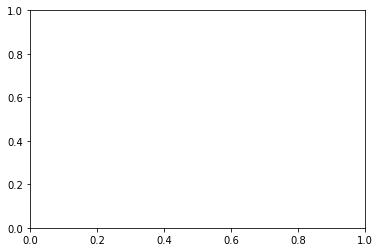

In [8]:
ax=plt.axes()
plt.plot([-15, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50], np.real(Psis),'o-')
ax.set_xlabel("gate voltage (V)")
ax.set_ylabel("Orientational Order Parameter")
plt.show()

In [ ]:
plt.plot([-15, -10, -5, 0, 5, 10, 15, 20, 30, 40, 50], np.imag(Psis))

In [ ]:
ax

In [ ]:
type(f2)

In [ ]:
len(range(10))

In [ ]:
test=[1,2]

In [ ]:
test2= ([1]+ test) - (test +[1])

In [ ]:
tes

In [ ]:
np.array([1]+[2,2,2])-np.array([1,1,1]+[2])

In [ ]:
np.array(test + [2*np.pi]) - np.array([0] + test)

In [ ]:
np.insert(test,0,0)

In [ ]:
np.append(test,0)

In [ ]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()
np.roll(vor.vertices, -1, axis=0)

In [ ]:
sorted_indices=np.argsort(np.mod(np.arctan2(vor.vertices[:,1],vor.vertices[:,0]),2*np.pi)/np.pi*180)

In [ ]:
new_vertices=vor.vertices[sorted_indices]

In [ ]:
side_lengths=new_vertices - np.roll(new_vertices, -1, axis=0)

In [ ]:
np.sqrt(side_lengths[:,0]**2+side_lengths[:,1]**2)

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d
def calculate_voronoi_lengths(neighbor_pos):
    vor = Voronoi(neighbor_pos)
    sorted_indices=np.argsort(np.mod(np.arctan2(vor.vertices[:,1],vor.vertices[:,0]),2*np.pi)/np.pi*180)
    new_vertices=vor.vertices[sorted_indices]
    side_vectors=new_vertices - np.roll(new_vertices, -1, axis=0)
    lengths=np.sqrt(side_vectors[:,0]**2+side_vectors[:,1]**2)
    fig = voronoi_plot_2d(vor)
    return lengths
points = np.array([[0,0],[1, 0], [1/2, np.sqrt(3)/2], [-1/2, np.sqrt(3)/2], [-1, 0], [-1/2, -np.sqrt(3)/2], [1/2, -np.sqrt(3)/2]])
lengths=calculate_voronoi_lengths(test)
print(lengths)

In [ ]:
fig = voronoi_plot_2d(vor)
plt.show()

In [ ]:
test/np.sum(test)

In [ ]:
for idx, n in enumerate(range(10)):
    print([idx,n])

In [ ]:
test=[[0,1],[2],[3,4,5]]

In [ ]:
for i,val in enumerate(test):
    print(val)

In [ ]:
neighbor_pos[0]

In [ ]:
np.insert([1,2],0,[3])

In [ ]:
test=[[159.12602965,  29.5461285 ],
 [150.54825291,  34.62728785],
 [140.27265745,  33.80414747],
 [177.55340557,  21.06037152],
 [146.38359375,  48.2859375 ],
 [143.80176861,  12.65070007],
 [160.70511841,  52.63865546],
 [182.83272727,  32.07127273]]

In [ ]:
np.roll([1,2,3],-1)-[1,2,3]

In [ ]:
np.concatenate(array([-3.15569027, -1.02039728, -1.04638098,  5.22246853]), array([ 2.66285426, -0.51112206,  1.6632146 , -2.62622022, -1.18872658]))

In [ ]:
np.average([1, 2, 3])